# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle

from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx

import arviz as az

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams["figure.figsize"] = (6, 4)
# mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.direction'] = 'inout'
mpl.rcParams['ytick.direction'] = 'inout'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

# System parameters

In [4]:
# from exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=149788158
#epoch_tess = ufloat(2459245.51846, 0.0032401)
epoch_tess = ufloat(2458518.087839, 0.001) # second detection
#period_tess = ufloat(4.7244442, 0.0000431)
period_tess = ufloat(0.75, 0.000013) # second detection
depth_tess = ufloat(3470.6759301685, 277.00897) # ppm
duration_tess = ufloat(0.999, 0.373)  # hours
radius_tess = ufloat(1.97562, 0.283431) # R_earth
insolation_tess = 6.29202 # S_earth

stteff_tess = ufloat(3653, 157)
strad_tess = ufloat(0.497204, 0.0147744)
stmass_tess = ufloat(0.495286, 0.0202891)

# RV reading

In [6]:
lbl_gl846 = pd.read_table('./lbl_toi727_gl846/lbl_TOI727_GL846.rdb', sep=None, engine='python', header=0)
lbl_toi727 = pd.read_table('./lbl_toi727_toi727/lbl_TOI727_TOI727.rdb', sep=None, engine='python', header=0)
lbl2_gl846 = pd.read_table('./lbl_toi727_gl846/lbl2_TOI727_GL846.rdb', sep=None, engine='python', header=0)
lbl2_gl846_new = pd.read_table('./new_montreal/lbl2_TOI727_GL846_bervzp.rdb', sep=None, engine='python', header=0)

lbl2_gl699_car = pd.read_table('./lbl2_carmona/lbl2_TOI727_GL699.rdb', sep=None, engine='python', header=0)
lbl2_gl699_car_vtot10 = pd.read_table('./lbl2_carmona/lbl2_TOI727_GL699_Vtot10corr.rdb', sep='\s+', engine='python', header=0)

lbl2_gl905_car = pd.read_table('./lbl2_carmona/lbl2_TOI727_GL905.rdb', sep=None, engine='python', header=0)
lbl2_gl905_car_vtot10 = pd.read_table('./lbl2_carmona/lbl2_TOI727_GL905_Vtot10corr.rdb', sep='\s+', engine='python', header=0)

lbl2_toi727_car = pd.read_table('./lbl2_carmona/lbl2_TOI727_TOI727.rdb', sep=None, engine='python', header=0)

#names = ['lbl_gl846', 'lbl_toi727']
#names = ['lbl2_gl699_car', 'lbl2_gl905_car', 'lbl2_toi727_car']
names = ['lbl2_gl846', 'lbl2_gl846_new']

star_name = 'toi727'

In [7]:
print(len(lbl2_gl846), len(lbl2_gl846_new))

35 35


In [8]:
datasets = list([lbl2_gl846, lbl2_gl846_new])
#datasets = list([lbl2_gl699_car, lbl2_gl905_car, lbl2_toi727_car])
#datasets = list([lbl2_gl699_car_vtot10, lbl2_gl905_car_vtot10, lbl2_gl846])

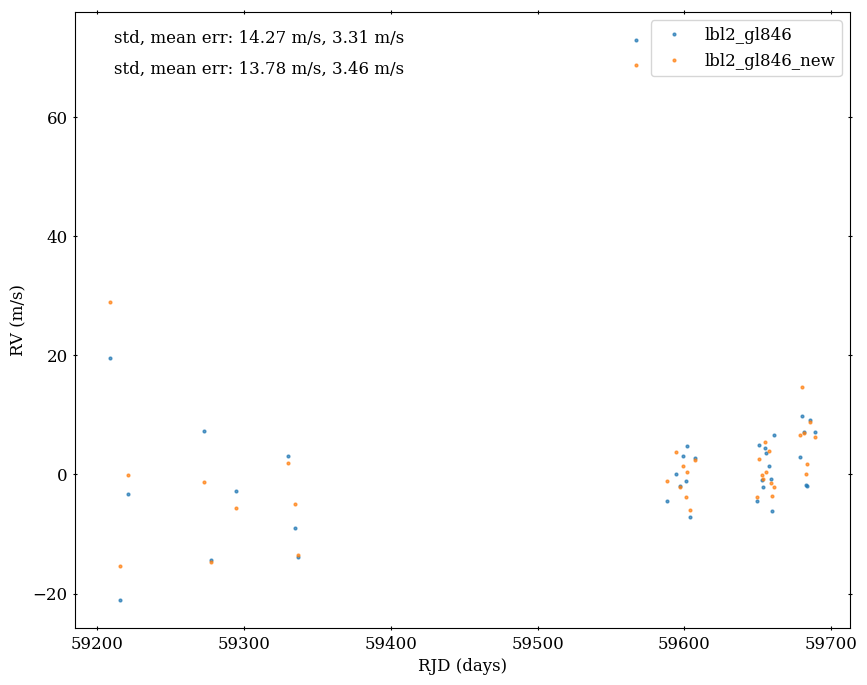

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, data in enumerate(datasets):
    ax.plot(data['rjd'], data['vrad']-np.median(data['vrad']), 'o', ms=2, label=names[i], alpha=0.7)
    ax.set_ylabel('RV (m/s)')
    ax.set_xlabel('RJD (days)')
    ax.text(0.05, 0.95-i*0.05, 'std, mean err: '+str(round(np.std(data['vrad']), 2))+' m/s, '+str(round(np.mean(data['svrad']),2))+' m/s', transform=ax.transAxes)
ax.legend(loc='upper right')
plt.savefig('rvs_'+star_name+'.png', dpi=300, facecolor='w')
plt.show()

## outliers?

In [10]:
for i in range(len(datasets)):
    print(datasets[i].shape)

(35, 172)
(35, 185)


In [11]:
outliers = []
for k, data in enumerate(datasets):
    sigmas = 3
    datasets[k] = data[np.abs(data['vrad'] - data['vrad'].mean()) <= (sigmas * data['vrad'].std())].reset_index(drop=True)
    a = np.abs(data['vrad'] - data['vrad'].mean()) <= (3 * data['vrad'].std())
    outliers.append(np.size(a) - np.count_nonzero(a))
print(outliers)

[1, 1]


In [12]:
# substract the systemic velocity 
for i in datasets:
    i['vrad'] = i['vrad'].apply(lambda x: x - i['vrad'].median())

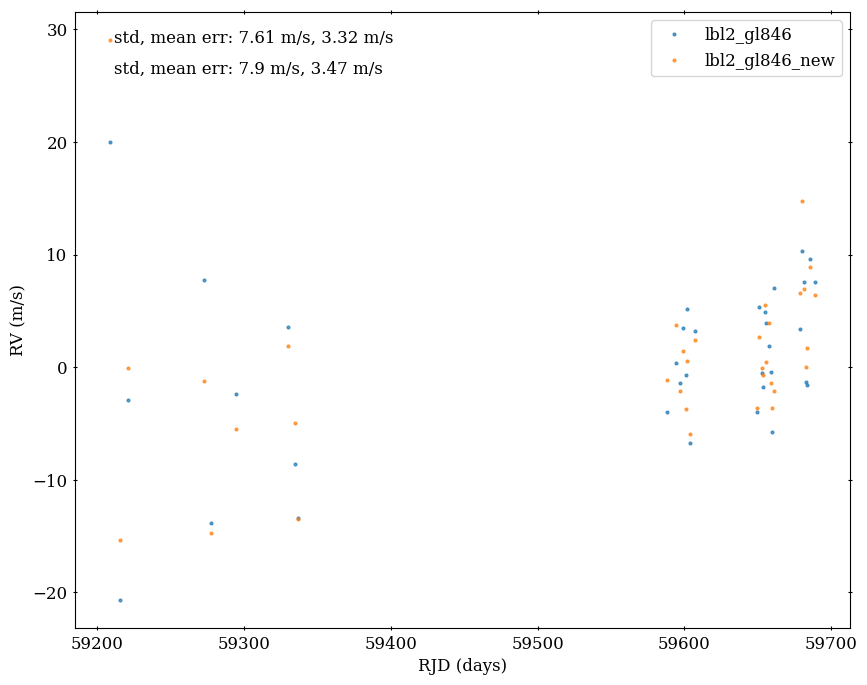

In [13]:
# replot without outliers
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i, data in enumerate(datasets):
    ax.plot(data['rjd'], data['vrad']-np.median(data['vrad']), 'o', ms=2, label=names[i], alpha=0.7)
    ax.set_ylabel('RV (m/s)')
    ax.set_xlabel('RJD (days)')
    ax.text(0.05, 0.95-i*0.05, 'std, mean err: '+str(round(np.std(data['vrad']), 2))+' m/s, '+str(round(np.mean(data['svrad']),2))+' m/s', transform=ax.transAxes)
ax.legend(loc='upper right')
plt.show()

# GLS

In [14]:
ls = dict()
frequency = dict()
power = dict()
faps = dict()

for k, data in enumerate(datasets):
    ls[k] = LombScargle(data['rjd'], data['vrad'], data['svrad'])
    frequency[k], power[k] = ls[k].autopower(minimum_frequency=0.01, maximum_frequency=2, samples_per_peak=15)
    probabilities = [0.01]
    faps[k] = ls[k].false_alarm_level(probabilities)

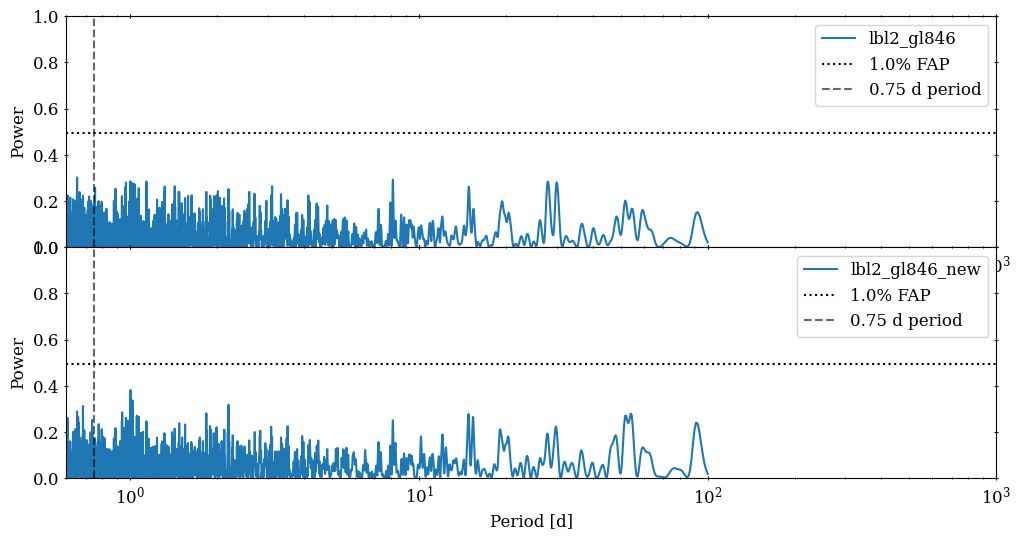

In [15]:
fig, axes = plt.subplots(len(datasets),1, sharex=False, figsize=(12, 3*len(datasets)))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(len(datasets)):
    axes[i].plot(1/frequency[i], power[i], label=names[i])
    axes[i].axhline(faps[i], ls=':', color='black', label='{}% FAP'.format(probabilities[0]*100))
    axes[i].set_xscale('log')
    axes[i].set_xlim(0.6, 1000)
    axes[i].set_ylim(0, 1.0)
    axes[i].set_ylabel('Power')
    axes[i].set_xlabel('Period [d]')
    axes[i].axvline(period_tess.n, ls='--', color='black', alpha=0.6, label='{} d period'.format(round(period_tess.n, 3)))
    axes[i].legend(loc='upper right')
    axes[i].set_ylim(0, 1)
plt.savefig('gls.png', dpi=300, facecolor='w')

# RV fit 

In [16]:
x_ref = dict()
maxrv = dict()
Kest = dict()
Kest2 = dict()

for k, data in enumerate(datasets):
    x_ref[k] = 0.5 * (data['rjd'].min() + data['rjd'].max())
    maxrv[k] = np.std(data['vrad'])*3
    #Ks = xo.estimate_semi_amplitude(period_tess.n, data['rjd'], data['vrad'], data['svrad'], t0s=epoch_tess.n-2400000)
    Kest[k] = xo.estimate_semi_amplitude(period_tess.n, data['rjd'], data['vrad'], data['svrad'], t0s=epoch_tess.n-2400000)
    Kest2[k] = xo.estimate_semi_amplitude(29.8, data['rjd'], data['vrad'], data['svrad'])
    print(Kest[k], "m/s 1")
    print(Kest2[k], "m/s 2")

[-0.84692035] m/s 1
[6.10449368] m/s 2
[-1.29064691] m/s 1
[5.5587312] m/s 2


In [17]:
epoch_tess.n-2400000

58518.08783899993

In [18]:
# Make a fine grid that spans the observation window for plotting purposes
model = dict()
t = dict()

for k, data in enumerate(datasets):
    t[k] = np.linspace(data['rjd'].min() - 5, data['rjd'].max() + 5, 3000)

    with pm.Model() as model[k]:
        #logP = pm.Normal("logP", mu=np.log(period_tess.n), sd=period_tess.s/period_tess.n)
        logP = pm.Normal("logP", mu=np.log(29.8), sd=2/29.8) 
        P = pm.Deterministic("P", tt.exp(logP))
        K = pm.Uniform("K", lower=0, upper=maxrv[k])
        #logK = pm.Normal("logK", mu=np.log(Kest2[k].item()), sd=2.0, testval=np.log(Kest2[k].item()))
        #K = pm.Deterministic("K", tt.exp(logK))

        logs = pm.Normal("logs", mu=np.log(np.median(data['svrad'])), sd=5.0)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)  # [2,1,0]

        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1)
        mstar = BoundedNormal("mstar", mu=stmass_tess.n, sd=stmass_tess.s)
        rstar = BoundedNormal("rstar", mu=strad_tess.n, sd=strad_tess.s)

        #t0 = pm.Normal("t0", mu=epoch_tess.n-2400000, sd=epoch_tess.s)
        #t0 = pm.Normal("t0", mu=epoch_tess.n-2400000, sd=10)
        t0 = pm.Uniform("t0", lower=58518.08783899993-14.8, upper=58518.08783899993+14.8)

        orbit = xo.orbits.KeplerianOrbit(period=P, 
                                        t0=t0, 
                                        r_star=rstar, 
                                        m_star=mstar)

        # derive mass and semi-major axis
        m_pl = pm.Deterministic('m_pl', K*(P*u.day.to(u.second)*(mstar*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3))
        a = pm.Deterministic('a', ((P*u.day.to(u.second))**2*constants.G*(mstar*u.M_sun.to(u.kg)+m_pl)/(4*np.pi**2))**(1/3)*u.m.to(u.au))

        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t, K=K)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref[k], 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)

        # Define the RVs at the observed times
        rv_model = get_rv_model(data['rjd'])
        # Also define the model on a fine grid as computed above (for plotting)
        rv_model_pred = get_rv_model(t[k], name="_pred")

        # Finally add in the observation model. 
        err = tt.sqrt(np.asarray(data['svrad'])**2  + tt.exp(2 * logs))
        pm.Normal("obs", mu=rv_model, sd=err, observed=data['vrad'])

In [19]:
for i in range(len(datasets)):
    with model[i]:
        map_soln = pmx.optimize(start=model[i].test_point)
        #map_soln = pmx.optimize(start=map_soln, vars=[logP, K, logs, t0])
        map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [t0, rstar, mstar, trend, logs, K, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -201.45859307182758 -> -107.16853914200101
optimizing logp for variables: [t0, rstar, mstar, trend, logs, K, logP]


message: Optimization terminated successfully.
logp: -107.16853914200101 -> -107.16853914200101


optimizing logp for variables: [t0, rstar, mstar, trend, logs, K, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -197.01715400602748 -> -109.2771329787113
optimizing logp for variables: [t0, rstar, mstar, trend, logs, K, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -109.2771329787113 -> -109.27713297871126


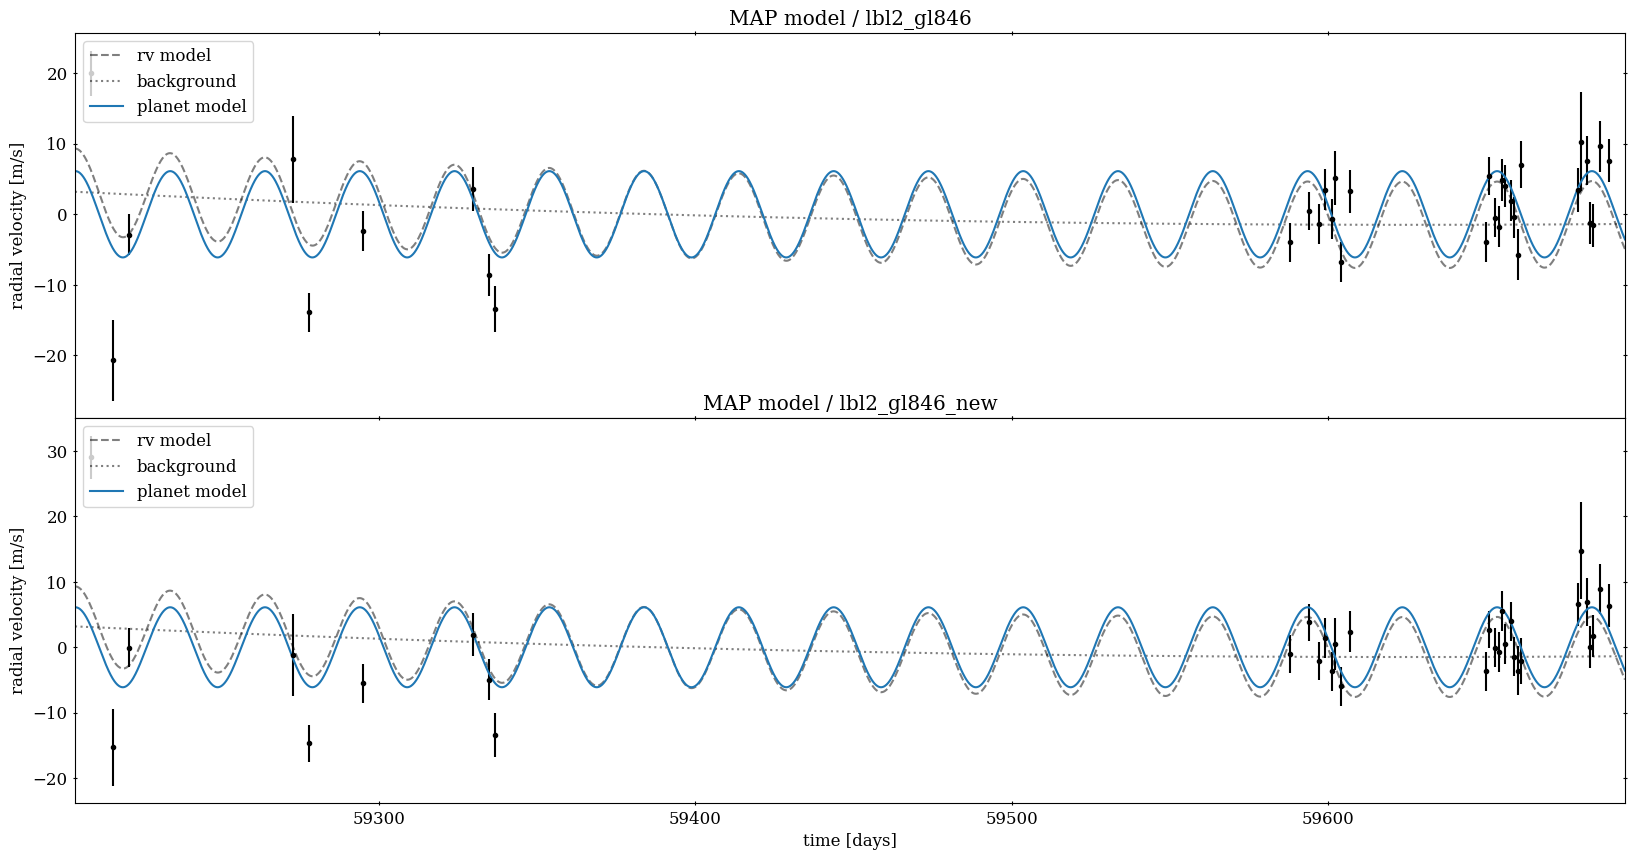

In [20]:
fig, ax = plt.subplots(len(datasets), 1, figsize=(20, 5*len(datasets)))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for k, data in enumerate(datasets):
    ax[k].errorbar(data['rjd'], data['vrad'], yerr=data['svrad'], fmt=".k")
    ax[k].plot(t[k], map_soln["rv_model_pred"], "--k", alpha=0.5, label='rv model')
    ax[k].plot(t[k], map_soln["bkg_pred"], ":k", alpha=0.5, label="background")
    ax[k].plot(t[k], map_soln["vrad_pred"], label="planet model")

    ax[k].legend(loc="upper left")
    ax[k].set_xlim(t[k].min(), t[k].max())
    ax[k].set_xlabel("time [days]")
    ax[k].set_ylabel("radial velocity [m/s]")
    _ = ax[k].set_title("MAP model"+' / '+names[k])

# Sampling

In [21]:
traces = dict()
for k, data in enumerate(datasets):
    with model[k]:
        traces[k] = pmx.sample(
            tune=2000,
            draws=2000,
            cores=2,
            chains=2,
            target_accept=0.95,
            return_inferencedata=True,
        )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0, rstar, mstar, trend, logs, K, logP]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0, rstar, mstar, trend, logs, K, logP]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.836584251807542, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [22]:
summary = dict()
for k, data in enumerate(datasets):
    summary[k] = az.summary(traces[k], stat_funcs={'median': np.median, 'std':np.std}, hdi_prob=0.997, round_to=6,
                var_names=[
                    't0', 'logP', 'P', 'K', 'logs', 'trend', 'mstar', 'rstar', 'm_pl', 'a'
                    ])
    print(summary[k].ess_bulk.mean(), summary[k].ess_tail.mean(), summary[k].r_hat.max())


1386.098712 1498.5308305833335 1.031097
413.40241983333334 763.9780339166665 1.166851


In [23]:
summary[0]

,mean,sd,hdi_0.15%,hdi_99.85%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
t0,5.851870e+04,7.750095e+00,5.850345e+04,5.853285e+04,2.275830e-01,1.609660e-01,1268.655571,1732.882815,1.001771,5.851881e+04,7.749126e+00
logP,3.377068e+00,3.561100e-02,3.269431e+00,3.531802e+00,4.357000e-03,3.094000e-03,58.609944,162.069671,1.031097,3.369753e+00,3.560700e-02
P,2.930353e+01,1.059560e+00,2.629636e+01,3.418550e+01,1.282220e-01,9.105700e-02,58.609944,162.069671,1.030915,2.907135e+01,1.059427e+00
K,4.341867e+00,2.259360e+00,6.770000e-03,1.121182e+01,8.892500e-02,6.290800e-02,619.515522,1003.732875,1.002487,4.240187e+00,2.259077e+00
logs,1.739547e+00,1.909170e-01,1.184783e+00,2.278039e+00,4.518000e-03,3.247000e-03,1756.680455,2367.216858,1.001273,1.740324e+00,1.908930e-01
trend[0],4.100000e-05,5.600000e-05,-1.250000e-04,2.030000e-04,3.000000e-06,2.000000e-06,260.922229,1419.025276,1.003645,4.100000e-05,5.600000e-05
trend[1],7.883000e-03,1.002800e-02,-2.706200e-02,3.550600e-02,6.080000e-04,4.300000e-04,274.770201,1449.449712,1.002036,8.303000e-03,1.002600e-02
trend[2],-5.709880e-01,9.524730e-01,-3.544625e+00,2.165252e+00,1.500800e-02,1.374700e-02,4025.842702,2951.538277,1.000692,-5.822200e-01,9.523540e-01
mstar,4.947000e-01,2.045000e-02,4.375070e-01,5.602680e-01,3.270000e-04,2.310000e-04,3919.260454,2847.601190,1.000013,4.947200e-01,2.044700e-02
rstar,4.972680e-01,1.490900e-02,4.535070e-01,5.428420e-01,2.460000e-04,1.740000e-04,3653.949851,2648.648747,1.000237,4.971150e-01,1.490700e-02


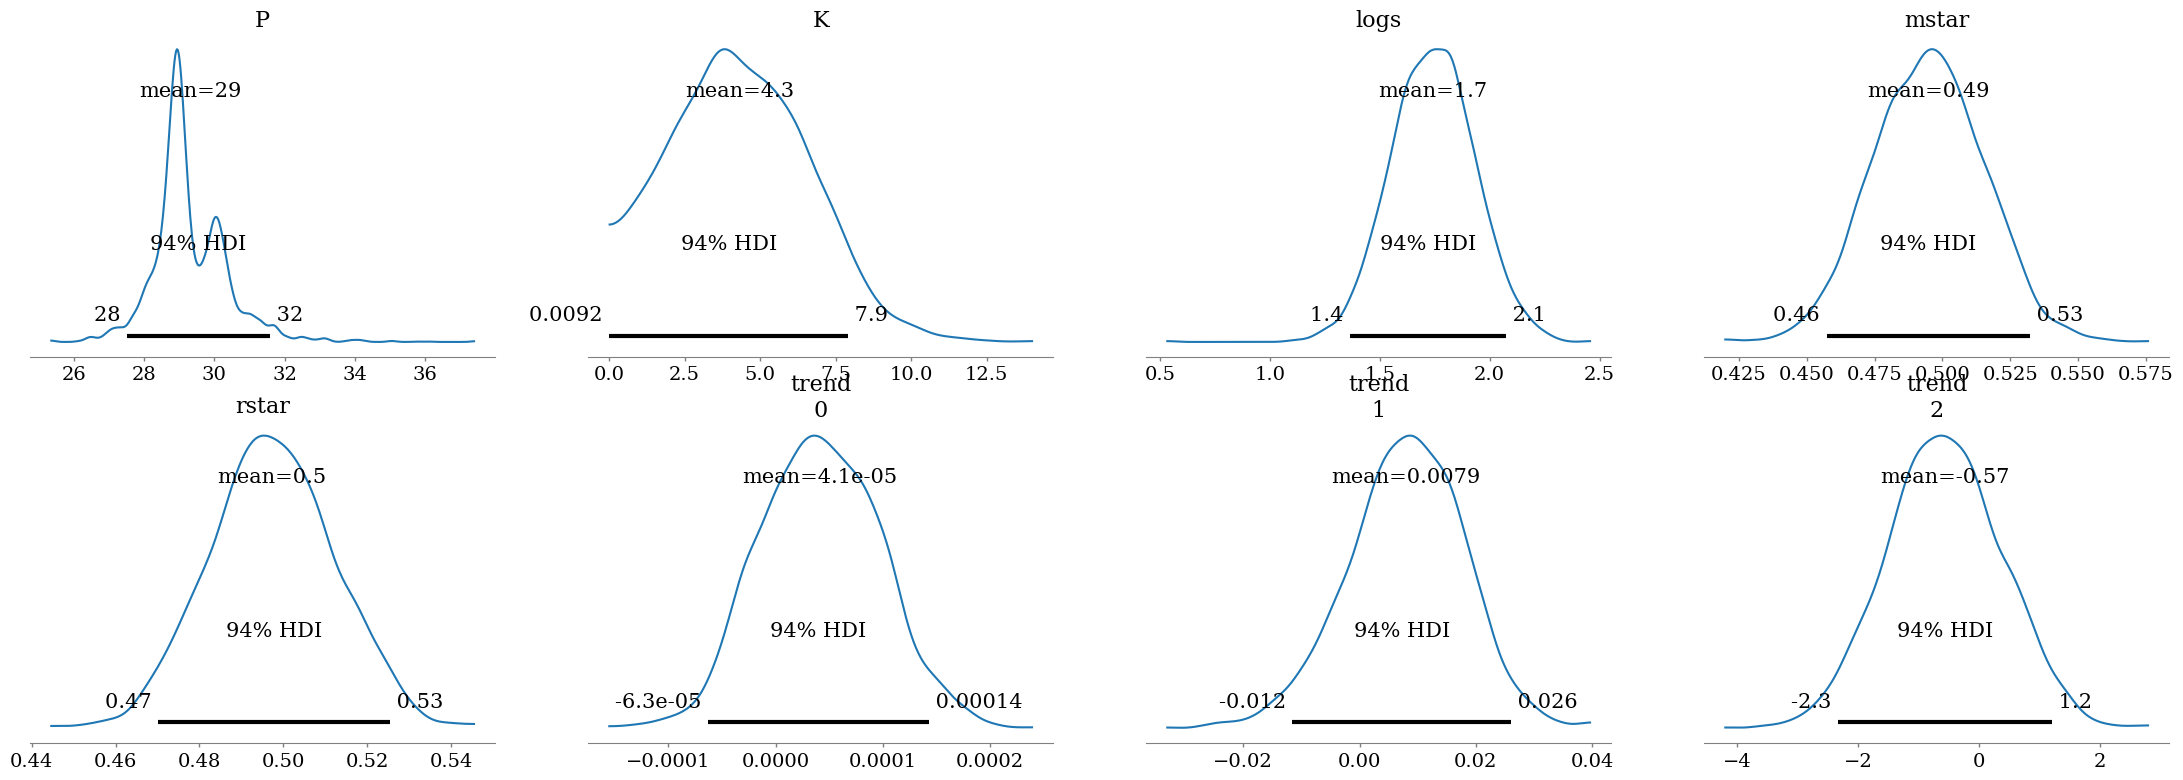

In [24]:
az.plot_posterior(traces[0], var_names=['P', 'K', 'logs', 'mstar', 'rstar', 'trend'])
plt.show()

## Results

In [25]:
mass = dict()
K = dict()
period = dict()
t_0 = dict()
m_star = dict()
r_star = dict()
smaxis = dict()
rv_jitter_ = dict()
bkg_ = dict()
rv_model = dict()
rv_model_pred = dict()
rv_model_pred_ = dict()
flat_samps = dict()

for i in range(len(datasets)):
    mass[i] = ufloat((traces[i].posterior["m_pl"].median().item()*u.kg).to(u.M_earth).value, (traces[i].posterior["m_pl"].std().item()*u.kg).to(u.M_earth).value)
    K[i] = ufloat(traces[i].posterior["K"].median().item(), traces[i].posterior["K"].std().item())
    period[i] = ufloat(traces[i].posterior['P'].median().item(),traces[i].posterior['P'].std().item())
    t_0[i] = ufloat(traces[i].posterior['t0'].median().item(), traces[i].posterior['t0'].std().item())
    m_star[i] = ufloat(traces[i].posterior['mstar'].median().item(), traces[i].posterior['mstar'].std().item())
    r_star[i] = ufloat(traces[i].posterior['rstar'].median().item(), traces[i].posterior['rstar'].std().item())
    smaxis[i] = ufloat(traces[i].posterior['a'].median().item(), traces[i].posterior['a'].std().item())
    logsigma_rv = ufloat(traces[i].posterior["logs"].median().item(), traces[i].posterior["logs"].std().item())
    rv_jitter_[i] = np.e**logsigma_rv
    flat_samps[i] = traces[i].posterior.stack(sample=("chain", "draw"))
    bkg_[i] = np.median(flat_samps[i]['bkg'].values, axis=-1)
    rv_model[i] = np.median(flat_samps[i]['rv_model'].values, axis=-1)

    rv_model_pred[i] = np.median(flat_samps[i]['rv_model_pred'].values, axis=-1)
    rv_model_pred_[i] = np.percentile(traces[i].posterior["rv_model_pred"].values,[16, 50, 84], axis=(0, 1))

    print('REDUCTION: ', names[i])
    print("Mp = {m:.3f} Mearth".format(m=mass[i]))
    print('K = {k:.3f} m/s'.format(k=K[i]))
    print("P = {p:.6f} days".format(p=period[i]))
    print("Epoch = {e:.5f}".format(e=t_0[i]))
    print('a = {a:.4f} AU'.format(a=smaxis[i]))
    print('mstar = {m:.3f} Msun'.format(m=m_star[i]))
    print('rstar = {r:.3f} Rsun'.format(r=r_star[i]))
    print("RV jitter = ", rv_jitter_[i])
    print('---------------------------------------------')

REDUCTION:  lbl2_gl846
Mp = 12.725+/-6.813 Mearth
K = 4.240+/-2.259 m/s
P = 29.071348+/-1.059427 days
Epoch = 58518.81433+/-7.74913
a = 0.1467+/-0.0041 AU
mstar = 0.495+/-0.020 Msun
rstar = 0.497+/-0.015 Rsun
RV jitter =  5.7+/-1.1
---------------------------------------------
REDUCTION:  lbl2_gl846_new
Mp = 15.472+/-8.011 Mearth
K = 5.151+/-2.703 m/s
P = 29.129269+/-1.139323 days
Epoch = 58515.18008+/-7.67201
a = 0.1459+/-0.0043 AU
mstar = 0.493+/-0.020 Msun
rstar = 0.496+/-0.014 Rsun
RV jitter =  6.0+/-1.1
---------------------------------------------


## Plot results

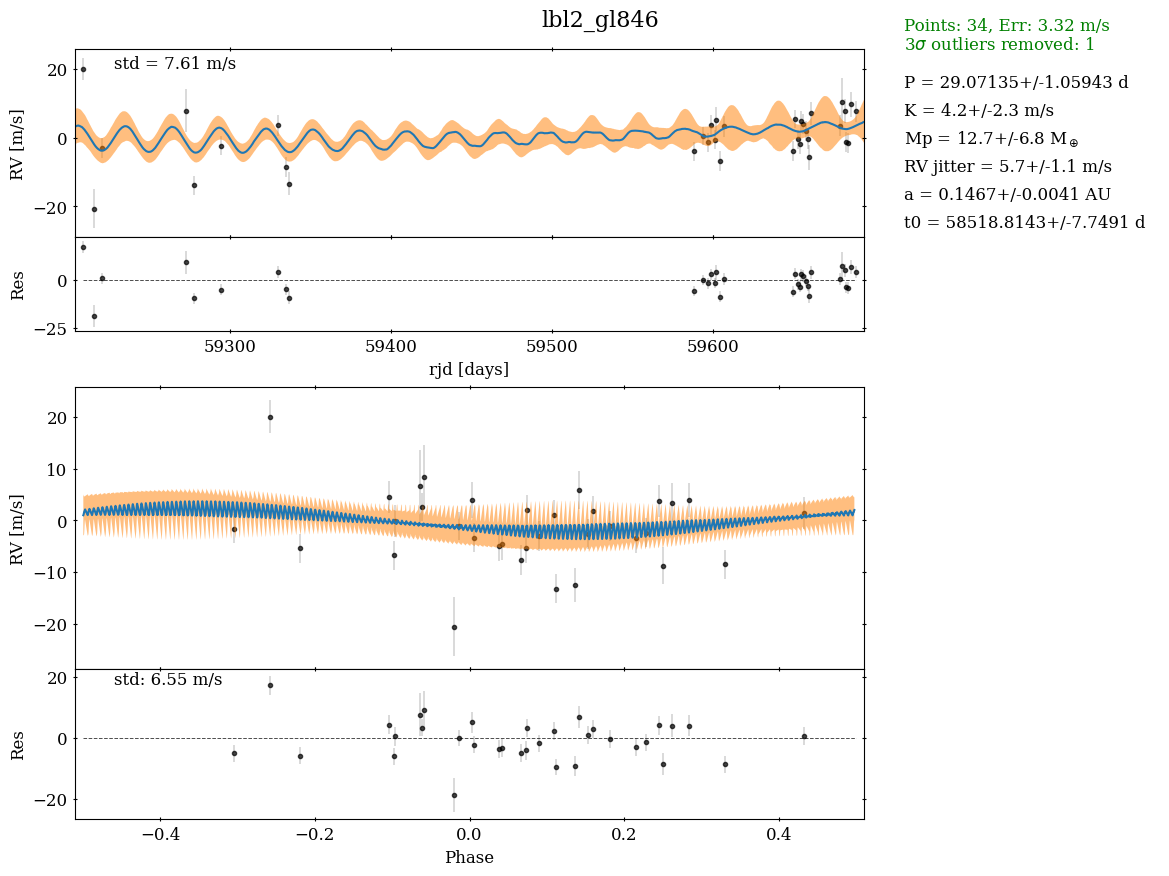

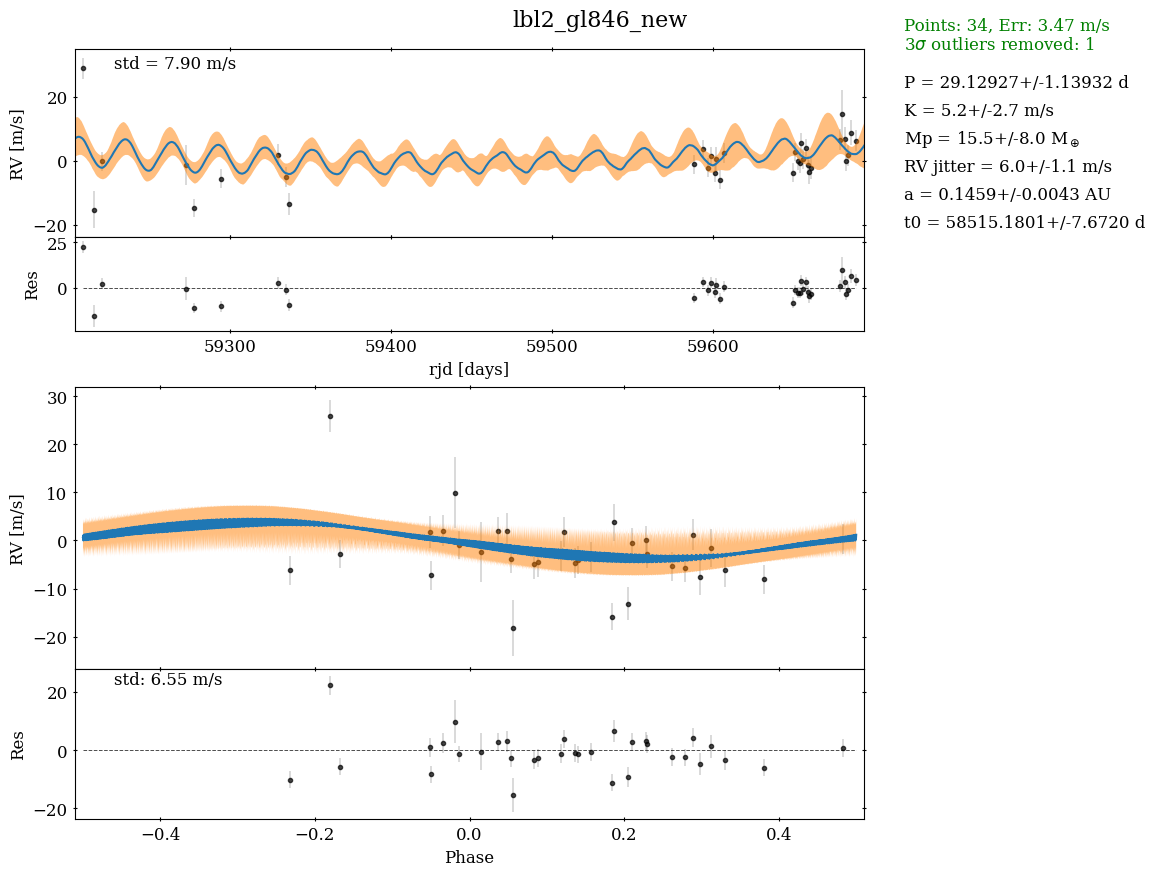

In [26]:
# make a grid of 3 subplots in a column
gs_kw = dict(width_ratios=[4,1], height_ratios=[1, 0.5, 0.3, 1.5, 0.8], hspace=0.0)

for k, data in enumerate(datasets):
    fig, ax = plt.subplots(5, 2, figsize=(14, 10), gridspec_kw=gs_kw)
    fig.suptitle(names[k], y=0.92, fontsize=16)
    # delete the three empty subplots and add the parameters in text
    for i in range(5):
        ax[i,1].xaxis.set_visible(False)
        ax[i,1].yaxis.set_visible(False)
        ax[i,1].spines['left'].set_visible(False)
        ax[i,1].spines['right'].set_visible(False)
        ax[i,1].spines['top'].set_visible(False)
        ax[i,1].spines['bottom'].set_visible(False)
        if i==0 or i==3:
            ax[i,0].set_xticks([])
            ax[i,0].set_xticklabels([])

    ax[0,1].text(-0.3, 1.1, 'Points: {o}, Err: {r:.2f} m/s'.format(o=len(data['vrad']), r=np.mean(data['svrad'])), fontsize=12, color='g')
    ax[0,1].text(-0.3, 1, '3$\sigma$ outliers removed: {o}'.format(o=outliers[k]), fontsize=12, color='g')
    ax[0,1].text(-0.3, 0.8, 'P = {p:.5f} d'.format(p=period[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.65, 'K = {k:.1f} m/s'.format(k=K[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.5, 'Mp = {m:.1f} M$_\oplus$'.format(m=mass[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.35, 'RV jitter = {j:.1f} m/s'.format(j=rv_jitter_[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.2, 'a = {a:.4f} AU'.format(a=smaxis[k]), fontsize=12)
    ax[0,1].text(-0.3, 0.05, 't0 = {t:.4f} d'.format(t=t_0[k]), fontsize=12)
    
    # plot the RVs and the model in the first subplot
    ax[0,0].errorbar(data['rjd'], data['vrad'], yerr=data['svrad'], fmt=".k", label='rvs', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[0,0].plot(t[k], rv_model_pred_[k][1], label='model')
    art = ax[0,0].fill_between(t[k], rv_model_pred_[k][0], rv_model_pred_[k][2], color="#FF7F00", alpha=0.5) 
    art.set_edgecolor("none")
    ax[0,0].set_ylabel("RV [m/s]")

    # add initial dispersion
    ax[0,0].text(0.05, 0.90, 'std = {s:.2f} m/s'.format(s=np.std(data['vrad'])), fontsize=12, transform=ax[0,0].transAxes)
    ax[0,0].sharex(ax[1,0])
    # add the residuals in the second subplot
    ax[1,0].hlines(0, data['rjd'].min(), data['rjd'].max(), ls='--', lw=0.7, alpha=0.7, color='k')
    ax[1,0].errorbar(data['rjd'], data['vrad']-rv_model[k], yerr=data['svrad'], fmt=".k", 
                    label='residuals', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[1,0].set_xlim(data['rjd'].min()-5, data['rjd'].max()+5)
    ax[1,0].set_xlabel("rjd [days]")
    ax[1,0].set_ylabel("Res")
    # plot the folded data
    x_fold = (data['rjd'] - t_0[k].n + 0.5 * period[k].n) % period[k].n - 0.5 * period[k].n
    ax[3,0].errorbar(x_fold/period[k].n, data['vrad']-bkg_[k], yerr=data['svrad'], fmt=".k",
                markeredgecolor='k', ecolor='k', elinewidth=0.3, label='', alpha=0.7, zorder=-10) 
    # delete the third subplot so it shows as a gap
    ax[2,0].set_visible(False)

    # compute the posterior prediction for the folded RV model
    t_fold = (t[k] - t_0[k].n + 0.5 * period[k].n) % period[k].n - 0.5 * period[k].n
    inds = np.argsort(t_fold)
    pred_rvs = np.percentile(traces[k].posterior["vrad_pred"].values,[16, 50, 84], axis=(0, 1))
    ax[3,0].plot(t_fold[inds]/period[k].n, pred_rvs[1][inds], label='folded model')
    art = ax[3,0].fill_between(t_fold[inds]/period[k].n, pred_rvs[0][inds], pred_rvs[2][inds], color="#FF7F00", alpha=0.5) 
    art.set_edgecolor("none")
    ax[3,0].set_ylabel("RV [m/s]")

    # plot the residuals
    ax[4,0].hlines(0, -0.5, 0.5, ls='--', lw=0.7, alpha=0.7, color='k')
    ax[4,0].errorbar(x_fold/period[k].n, data['vrad']-rv_model[k], yerr=data['svrad'], fmt=".k", 
                    label='residuals', markeredgecolor='k', ecolor='k', elinewidth=0.3, alpha=0.7, zorder=-10)
    ax[4,0].set_xticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax[4,0].set_ylabel("Res")
    ax[4,0].set_xlabel("Phase")
    # show the std of the residuals
    ax[4,0].text(0.05, 0.90, 'std: '+str(round(np.std(data['vrad']-rv_model[k]), 2))+' m/s', transform=ax[4,0].transAxes)
    ax[4,0].set_xlim(-0.51, 0.51)
    ax[4,0].set_xticks([-0.40, -0.20, 0, 0.40, 0.20])
    ax[3,0].sharex(ax[4,0])
    # savefig with name
    plt.savefig('fit_'+names[k]+'.png', dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

# Limit mass

In [27]:
def limit_mass(K, ecc, period, m_star):
    return K*np.sqrt(1-ecc**2)*(period*u.day.to(u.second)*(m_star*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3)*u.kg.to(u.M_earth)

# compute the mass upper limit from 3 sigma upper limit on K
Ks = np.percentile(traces[0].posterior["K"].values,[0.015, 50, 99.85], axis=(0, 1))
limit_mass(Ks[2], 0.0, period[0], stmass_tess.n).n

35.214840914225036